<a href="https://colab.research.google.com/github/SapateAtharva/Aerospace-Components-Export-Performance-Analysis/blob/main/Aerospace_Components_Export_Performance_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [77]:
# --- Constants ---
DATA_FILE = 'https://raw.githubusercontent.com/SapateAtharva/Aerospace-Components-Export-Performance-Analysis/main/aerospace_exports.csv'
START_YEAR = 2019
END_YEAR = 2023
FORECAST_YEARS = [2024, 2025]

In [78]:
def run_data_science_pipeline():
    """
    Main function to execute the full data science pipeline.
    """
    print("--- Starting Data Science Mini-Project ---")

    # --- 1. ETL (Extract, Transform, Load) ---
    df = load_and_transform_data(DATA_FILE)
    if df is None:
        return

    # --- 2. Data Preprocessing ---
    # (Checking for nulls is handled in the load_and_transform_data function)
    print("\nData preprocessed successfully.")
    print("First 5 rows of data:")
    print(df.head())
    print("DataFrame columns in main pipeline:", df.columns) # Add this line to check columns


    # --- 3. Exploratory Data Analysis (EDA) ---
    print("\n--- Starting Exploratory Data Analysis (EDA) ---")
    run_eda(df)
    print("EDA plots generated and saved to 'plots/' directory.")

    # --- 4. Model Selection ---
    # We are selecting Linear Regression for its simplicity and interpretability
    # to model the time-series trend.

    # --- 5. Model Training and Evaluation ---
    print("\n--- Starting Model Training & Evaluation ---")

    # We need to aggregate data to get total exports per year for forecasting
    df_agg = df.groupby('Year')['ExportValue_USD_Millions'].sum().reset_index()

    # Split data: Train on 2019-2022, Test on 2023
    train_data = df_agg[df_agg['Year'] < END_YEAR]
    test_data = df_agg[df_agg['Year'] == END_YEAR]

    # Prepare data for Scikit-learn
    X_train = train_data[['Year']]
    y_train = train_data['ExportValue_USD_Millions']
    X_test = test_data[['Year']]
    y_test = test_data['ExportValue_USD_Millions']

    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    print("Model trained successfully.")

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    print("\n--- Model Evaluation Results (on 2023 Test Data) ---")
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"R-squared (R²): {r2:.4f}")
    print(f"Mean Absolute Error (MAE): ${mae:.2f} Million")
    print(f"Root Mean Squared Error (RMSE): ${rmse:.2f} Million")

    print("\nActual vs. Predicted for 2023:")
    print(f"  Actual: ${y_test.values[0]:.2f} Million")
    print(f"  Predicted: ${y_pred[0]:.2f} Million")

    # --- 6. Result and Visuals (Forecasting) ---
    print("\n--- Generating Final Forecast Plot ---")
    generate_forecast_plot(model, df_agg)
    print("Forecast plot saved to 'plots/final_forecast_plot.png'")

    print("\n--- Data Science Mini-Project Completed ---")

In [79]:
def load_and_transform_data(filepath):
    """
    Loads, cleans, and transforms the initial dataset.
    """
    print(f"1. [ETL] Extracting data from '{filepath}'...")
    try:
        df = pd.read_csv(filepath, sep=',', engine='python')
    except FileNotFoundError:
        print(f"Error: Data file '{filepath}' not found.")
        return None
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return None


    print("2. [ETL] Transforming data...")
    # Clean the 'Year' column (e.g., "2019-20" -> 2019)
    df['Year'] = df['Year'].astype(str).str.split('-').str[0].astype(int)

    # Check for missing values
    if df.isnull().sum().sum() > 0:
        print("Warning: Missing values detected. Filling with 0 for this demo.")
        df.fillna(0, inplace=True)

    print("3. [ETL] Loading data into DataFrame.")
    return df

In [80]:
def run_eda(df):
    """
    Generates and saves all EDA plots.
    """
    # Create a directory to save plots
    import os
    if not os.path.exists('plots'):
        os.makedirs('plots')

    plt.style.use('seaborn-v0_8-darkgrid')

    # Plot 1: Total Export Trend Over Time
    plt.figure(figsize=(10, 6))
    df_agg_total = df.groupby('Year')['ExportValue_USD_Millions'].sum()
    sns.lineplot(x=df_agg_total.index, y=df_agg_total.values, marker='o', lw=3)
    plt.title('Total Aerospace Exports from India (2019-2023)', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Total Export Value (USD Millions)', fontsize=12)
    plt.xticks(range(START_YEAR, END_YEAR + 1))
    plt.savefig('plots/total_export_trend.png')
    plt.show() # Display the plot
    plt.close()

    # Plot 2: Export Value by Component (Total)
    plt.figure(figsize=(10, 6))
    df_agg_comp = df.groupby('Component')['ExportValue_USD_Millions'].sum().sort_values(ascending=False)
    sns.barplot(x=df_agg_comp.values, y=df_agg_comp.index, palette='viridis', hue=df_agg_comp.index, legend=False) # Added hue and legend=False
    plt.title('Total Export Value by Component (2019-2023)', fontsize=16)
    plt.xlabel('Total Export Value (USD Millions)', fontsize=12)
    plt.ylabel('Component', fontsize=12)
    plt.savefig('plots/component_total_exports.png')
    plt.show() # Display the plot
    plt.close()

    # Plot 3: Component Export Trends Over Time
    plt.figure(figsize=(12, 7))
    sns.lineplot(data=df, x='Year', y='ExportValue_USD_Millions', hue='Component', marker='o', lw=2.5)
    plt.title('Component-wise Export Trends (2019-2023)', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Export Value (USD Millions)', fontsize=12)
    plt.xticks(range(START_YEAR, END_YEAR + 1))
    plt.legend(title='Component')
    plt.savefig('plots/component_yearly_trends.png')
    plt.show() # Display the plot
    plt.close()

    # Plot 4: Export Share by Component (Latest Year)
    plt.figure(figsize=(10, 8))
    df_latest = df[df['Year'] == END_YEAR]
    plt.pie(df_latest['ExportValue_USD_Millions'], labels=df_latest['Component'], autopct='%1.1f%%',
            startangle=90, colors=sns.color_palette('plasma', n_colors=len(df_latest)))
    plt.title(f'Export Share by Component ({END_YEAR})', fontsize=16)
    plt.savefig('plots/component_pie_chart_latest_year.png')
    plt.show() # Display the plot
    plt.close()

    # Plot 5: Correlation Heatmap (Advanced EDA)
    print("DataFrame columns:", df.columns) # Add this line to print columns
    plt.figure(figsize=(8, 6))
    # Pivot data to run correlation
    df_pivot = df.pivot(index='Year', columns='Component', values='ExportValue_USD_Millions')
    df_pivot['Gov_Incentive_Total'] = df.groupby('Year')['Gov_Incentive_Millions'].sum() # Corrected column name
    df_pivot['Total_Exports'] = df.groupby('Year')['ExportValue_USD_Millions'].sum()

    corr = df_pivot.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Heatmap', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('plots/correlation_heatmap.png')
    plt.show() # Display the plot
    plt.close()

--- Starting Data Science Mini-Project ---
1. [ETL] Extracting data from 'https://raw.githubusercontent.com/SapateAtharva/Aerospace-Components-Export-Performance-Analysis/main/aerospace_exports.csv'...
2. [ETL] Transforming data...
3. [ETL] Loading data into DataFrame.

Data preprocessed successfully.
First 5 rows of data:
   Year          Component  ExportValue_USD_Millions  Gov_Incentive_Millions
0  2019           Avionics                     120.5                    12.0
1  2019  Engine_Components                     200.0                    20.0
2  2019     Fuselage_Parts                      80.0                     8.0
3  2019       Landing_Gear                      60.5                     6.0
4  2020           Avionics                     150.0                    15.0
DataFrame columns in main pipeline: Index(['Year', 'Component', 'ExportValue_USD_Millions',
       'Gov_Incentive_Millions'],
      dtype='object')

--- Starting Exploratory Data Analysis (EDA) ---


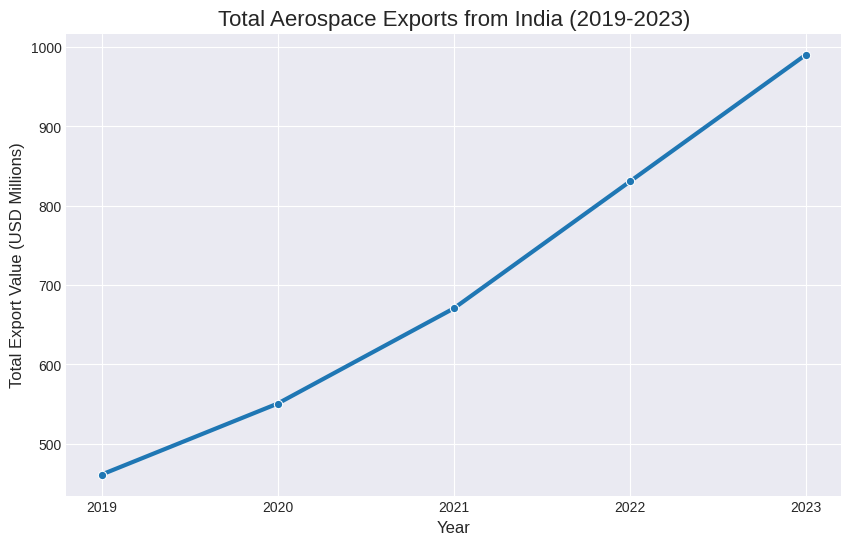

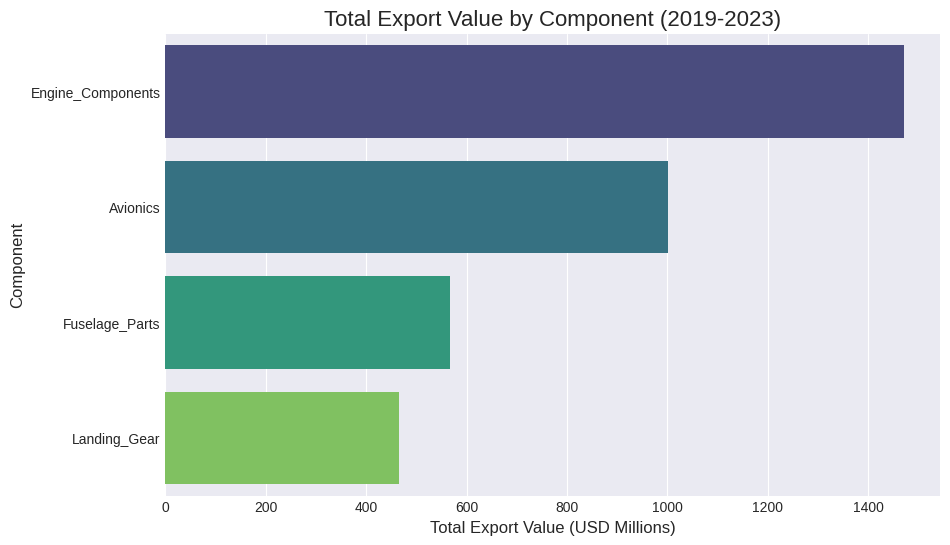

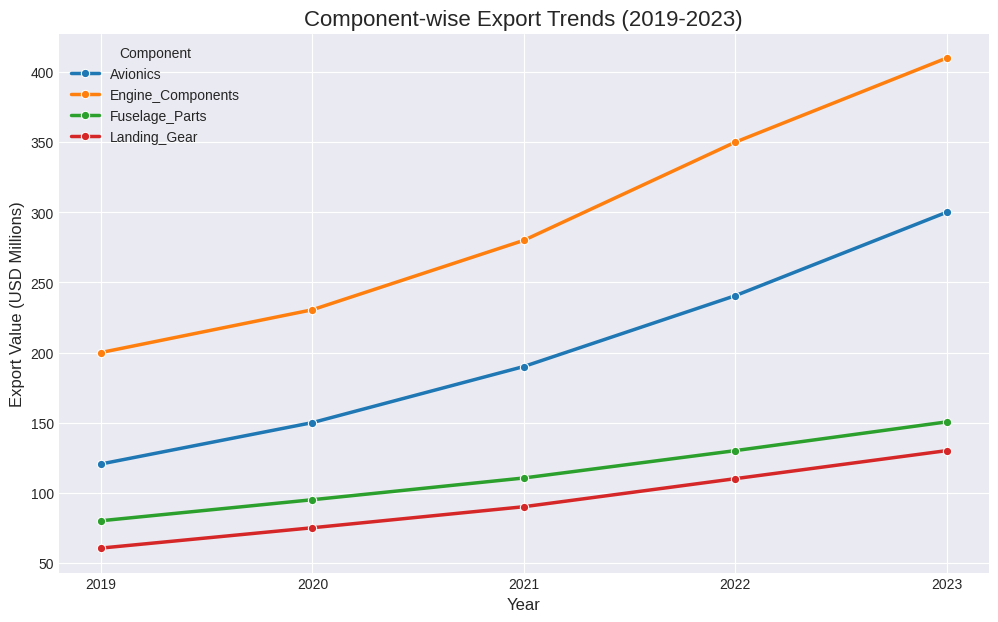

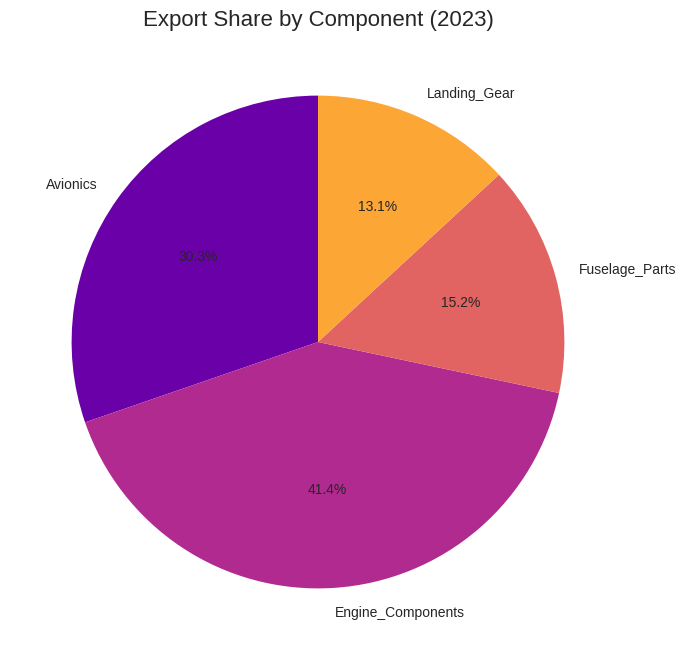

DataFrame columns: Index(['Year', 'Component', 'ExportValue_USD_Millions',
       'Gov_Incentive_Millions'],
      dtype='object')


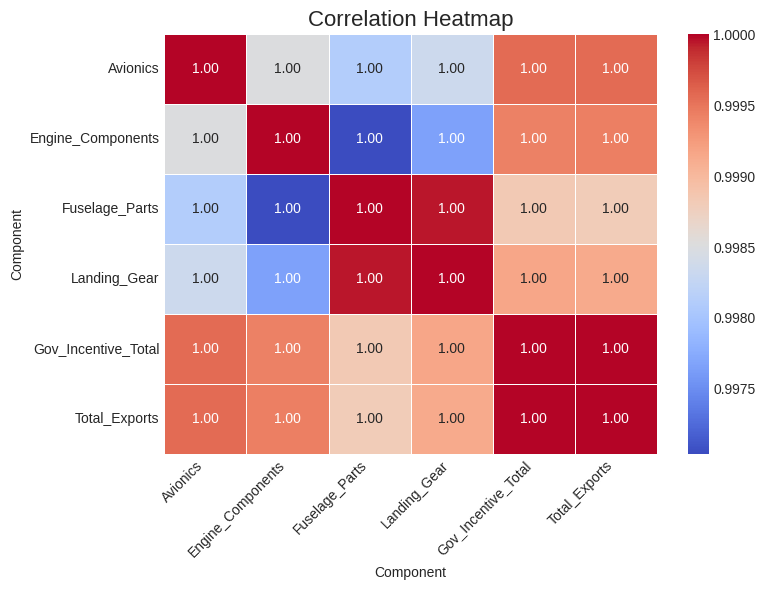

EDA plots generated and saved to 'plots/' directory.

--- Starting Model Training & Evaluation ---
Model trained successfully.

--- Model Evaluation Results (on 2023 Test Data) ---
R-squared (R²): nan
Mean Absolute Error (MAE): $55.25 Million
Root Mean Squared Error (RMSE): $55.25 Million

Actual vs. Predicted for 2023:
  Actual: $990.50 Million
  Predicted: $935.25 Million

--- Generating Final Forecast Plot ---

--- Future Forecast ---
  2024 (Forecasted): $1058.10 Million
  2025 (Forecasted): $1180.95 Million


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Forecast plot saved to 'plots/final_forecast_plot.png'

--- Data Science Mini-Project Completed ---


In [81]:
run_data_science_pipeline()